In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import plotly.graph_objects as go


from sklearn.preprocessing import MinMaxScaler #notused
from sklearn.preprocessing import StandardScaler #notused

from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from pmdarima import auto_arima
from sklearn.ensemble import IsolationForest

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('data/train.csv')
train

,DATETIME,SERVER,CPU,CPULOAD
0,2020-03-24 00:00:00+03:00,CIHAZ_301,CPU-0,3.88
1,2020-03-24 00:00:00+03:00,CIHAZ_301,CPU-1,11.33
2,2020-03-24 00:00:00+03:00,CIHAZ_301,CPU-10,5.31
3,2020-03-24 00:00:00+03:00,CIHAZ_301,CPU-11,5.25
4,2020-03-24 00:00:00+03:00,CIHAZ_301,CPU-12,0.28
...,...,...,...,...
312691,2020-05-30 23:45:00+03:00,CIHAZ_305,CPU-5,16.17
312692,2020-05-30 23:45:00+03:00,CIHAZ_305,CPU-6,16.02
312693,2020-05-30 23:45:00+03:00,CIHAZ_305,CPU-7,14.14
312694,2020-05-30 23:45:00+03:00,CIHAZ_305,CPU-8,15.42


In [3]:
train.info() #no missing data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312696 entries, 0 to 312695
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   DATETIME  312696 non-null  object 
 1   SERVER    312696 non-null  object 
 2   CPU       312696 non-null  object 
 3   CPULOAD   312696 non-null  float64
dtypes: float64(1), object(3)
memory usage: 9.5+ MB


In [4]:
train.describe()

,CPULOAD
count,312696.000000
mean,10.283954
std,9.904820
min,0.060000
25%,2.050000
50%,6.820000
75%,16.040000
max,68.840000


In [5]:
mean = train.CPULOAD.mean()
std = train.CPULOAD.std()

lower_bound = mean-(std*3)
upper_bound = mean+(std*3)

print(f'Upper bound : {upper_bound} - Lower bound : {lower_bound}')#Normal data should be within this range. Minimum and maximum values must be within these limits.

Upper bound : 39.9984135108327 - Lower bound : -19.4305061503292


In [6]:
train["DATETIME"] = pd.to_datetime(train["DATETIME"], format="%Y-%m-%d %H:%M:%S%z", errors = 'coerce') #Converting data to datetime object according to the format of the data
train['HOUR'] = train['DATETIME'].dt.strftime('%H:%M') #estimation will be made by grouping by hour

In [8]:
train

,DATETIME,SERVER,CPU,CPULOAD,HOUR
0,2020-03-24 00:00:00+03:00,CIHAZ_301,CPU-0,3.88,00:00
1,2020-03-24 00:00:00+03:00,CIHAZ_301,CPU-1,11.33,00:00
2,2020-03-24 00:00:00+03:00,CIHAZ_301,CPU-10,5.31,00:00
3,2020-03-24 00:00:00+03:00,CIHAZ_301,CPU-11,5.25,00:00
4,2020-03-24 00:00:00+03:00,CIHAZ_301,CPU-12,0.28,00:00
...,...,...,...,...,...
312691,2020-05-30 23:45:00+03:00,CIHAZ_305,CPU-5,16.17,23:45
312692,2020-05-30 23:45:00+03:00,CIHAZ_305,CPU-6,16.02,23:45
312693,2020-05-30 23:45:00+03:00,CIHAZ_305,CPU-7,14.14,23:45
312694,2020-05-30 23:45:00+03:00,CIHAZ_305,CPU-8,15.42,23:45


CIHAZ_301 cihazındaki Veri normal dağılıma sahip değildir.


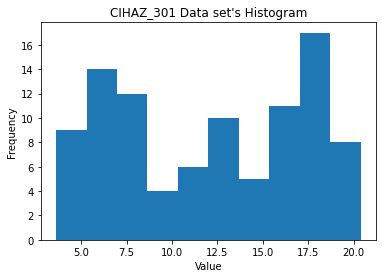

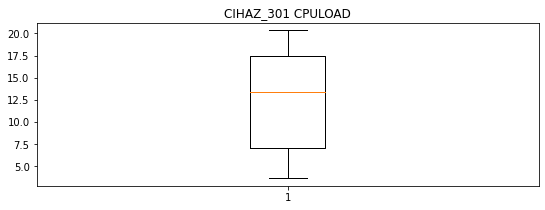

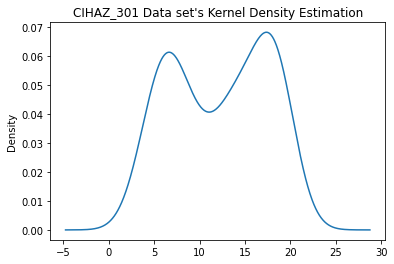

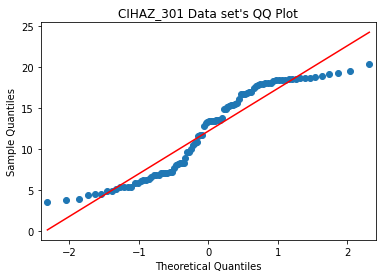

CIHAZ_305 cihazındaki Veri normal dağılıma sahip değildir.


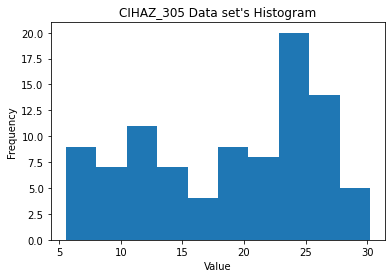

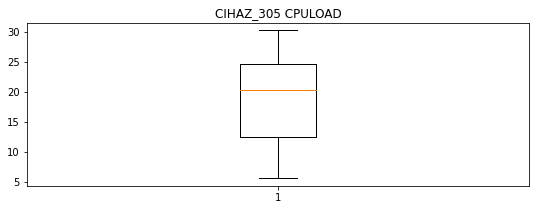

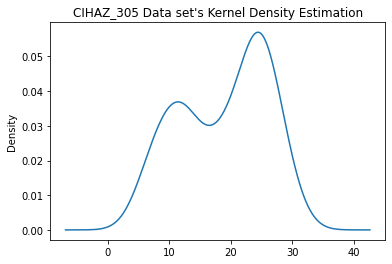

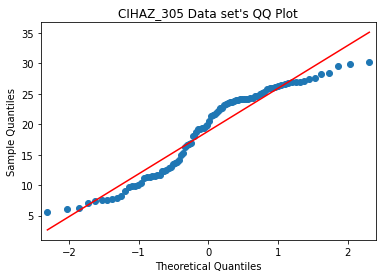

In [7]:
#for data within the same day

day = 16
for server in train['SERVER'].unique():
    subdata = train[(train['SERVER']==server) & (train['CPU']=='CPU-0') &  (train.DATETIME>=("2020-05-"+str(day)))&  ("2020-05-"+str(day+1)>train.DATETIME)]
    
    stat, p_value = stats.shapiro(subdata['CPULOAD'])
    
    if p_value > .05:
        print(f"{server} cihazındaki Veri normal dağılıma sahiptir.")
    else:
        print(f"{server} cihazındaki Veri normal dağılıma sahip değildir.")
    
    plt.hist(subdata['CPULOAD'], bins=10)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title(f'{server} Data set\'s Histogram')
    plt.show()
    
    plt.figure(figsize=(9, 3))
    plt.boxplot(subdata['CPULOAD'])
    plt.title(f"{server} CPULOAD")
    plt.show()
    
    subdata['CPULOAD'].plot.kde()
    plt.title(f'{server} Data set\'s Kernel Density Estimation')
    plt.show()
    
    
    sm.qqplot(subdata['CPULOAD'], line = "s")
    plt.title(f'{server} Data set\'s QQ Plot')
    plt.show()
    
    #Data are uniformly distributed

CIHAZ_301 cihazındaki Veri normal dağılıma sahip değildir.


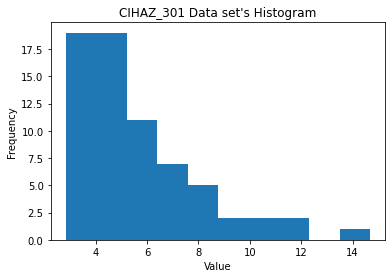

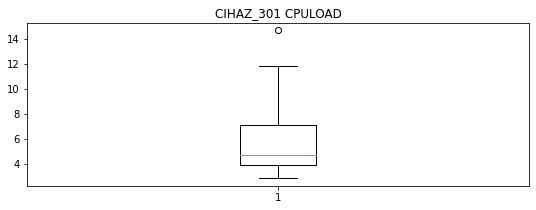

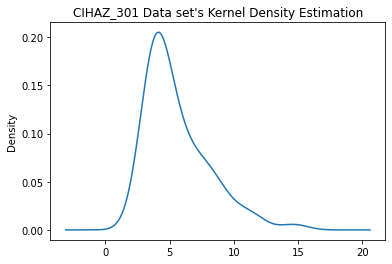

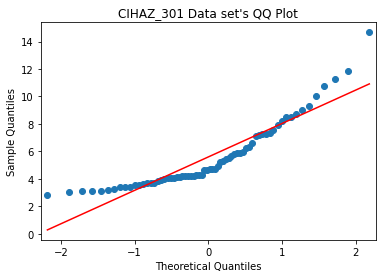

CIHAZ_305 cihazındaki Veri normal dağılıma sahiptir.


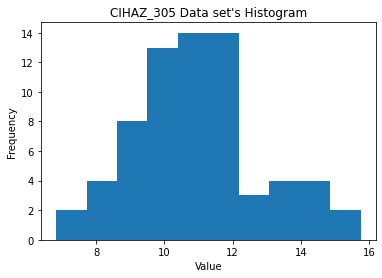

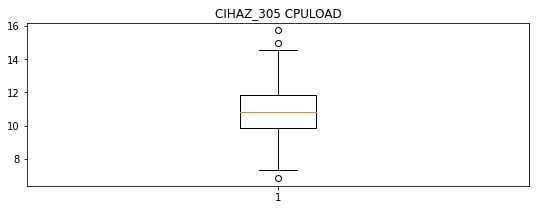

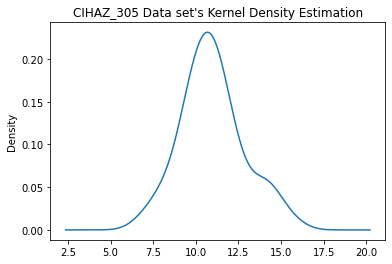

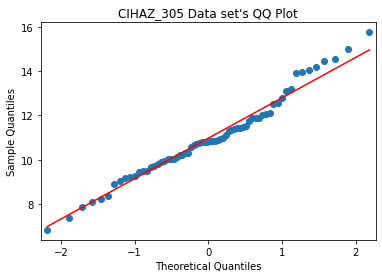

In [11]:
#for data within the same hour
hour = '01:00' 

for server in train['SERVER'].unique():
    subdata = train[(train['SERVER']==server) & (train['CPU']=='CPU-0') &  (train.HOUR==hour)]
    
    stat, p_value = stats.shapiro(subdata['CPULOAD'])
    
    if p_value > .05:
        print(f"{server} cihazındaki Veri normal dağılıma sahiptir.")
    else:
        print(f"{server} cihazındaki Veri normal dağılıma sahip değildir.")
    
    plt.hist(subdata['CPULOAD'], bins=10)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title(f'{server} Data set\'s Histogram')
    plt.show()
    
    plt.figure(figsize=(9, 3))
    plt.boxplot(subdata['CPULOAD'])
    plt.title(f"{server} CPULOAD")
    plt.show()
    
    subdata['CPULOAD'].plot.kde()
    plt.title(f'{server} Data set\'s Kernel Density Estimation')
    plt.show()
    
    
    sm.qqplot(subdata['CPULOAD'], line = "s")
    plt.title(f'{server} Data set\'s QQ Plot')
    plt.show()
    
    #Data are uniformly distributed

In [ ]:
train[(train['SERVER']==server) & (train['CPU']=='CPU-0') &  (train.DATETIME>=("2020-05-"+str(day)))&  ("2020-05-"+str(day+1)>train.DATETIME)]

In [195]:
subdata = train[(train['SERVER']=='CIHAZ_301') & (train['CPU']=='CPU-0') & (train['HOUR']=='00:00')]
model = auto_arima(subdata['CPULOAD'].values, seasonal=False, trace=True)

print(model.summary())
# View the summary of the top model
#For parameter optimization

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=459.600, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=380.822, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=426.462, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=361.458, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=361.100, Time=0.05 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=362.556, Time=0.07 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=355.081, Time=0.14 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=356.169, Time=0.08 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=357.080, Time=0.13 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=354.783, Time=0.19 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=inf, Time=0.37 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=357.909, Time=0.12 se

In [159]:
def data_prediction(data):
    
    new_data = []
    index = 0

    for hour in data['HOUR'].unique(): #roaming every hour zone
    
        for server in data['SERVER'].unique(): #roaming every server zone
            
            for cpu in data['CPU'].unique(): #roaming every cpu zone
                
                subdata = data[(data['SERVER']==server) & (data['CPU']==cpu) & (data['HOUR']==hour)] #I am parsing data according to constraints. To do the estimation in time grouping
                X= subdata['CPULOAD'].values
                
                model = ARIMA(X, order=(2, 0, 1))
                model_fit = model.fit()
                next_prediction = model_fit.forecast(steps=1)
                
                dt = "2020-03-31 "+hour+":00+03:00"
                print(f"DATETIME: {dt} - Server: {server} - CPU: {cpu} - Prediction: {next_prediction[0]}")
                
                new_row = {'DATETIME': "2020-03-31 "+hour+":00+03:00", 'SERVER': server, 'CPU': cpu, 'CPULOAD': next_prediction[0]}
                new_data.append(new_row)
                
    return new_data

In [317]:
order_201 = data_prediction(train)

order_201 = pd.DataFrame(order_201)
merged_df = pd.DataFrame()  #Empty dataframe to combine results

for date in order_201.DATETIME.unique():
    subdata = order_201[order_201['DATETIME']==date]
    mean = subdata.groupby('SERVER')['CPULOAD'].mean().reset_index()
    merged_df = pd.concat([merged_df, mean], ignore_index=True)
    
merged_df['CPULOAD'].to_csv('submission_201.csv',index=True)

DATETIME: 2020-03-31 00:00:00+03:00 - Server: CIHAZ_301 - CPU: CPU-0 - Prediction: 7.702138179779564
DATETIME: 2020-03-31 00:00:00+03:00 - Server: CIHAZ_301 - CPU: CPU-1 - Prediction: 12.75962933330479
DATETIME: 2020-03-31 00:00:00+03:00 - Server: CIHAZ_301 - CPU: CPU-10 - Prediction: 8.424439045072504
DATETIME: 2020-03-31 00:00:00+03:00 - Server: CIHAZ_301 - CPU: CPU-11 - Prediction: 7.777795956930862
DATETIME: 2020-03-31 00:00:00+03:00 - Server: CIHAZ_301 - CPU: CPU-12 - Prediction: 0.8002546155483239
DATETIME: 2020-03-31 00:00:00+03:00 - Server: CIHAZ_301 - CPU: CPU-13 - Prediction: 1.7018604920615938
DATETIME: 2020-03-31 00:00:00+03:00 - Server: CIHAZ_301 - CPU: CPU-14 - Prediction: 0.9090307893355187
DATETIME: 2020-03-31 00:00:00+03:00 - Server: CIHAZ_301 - CPU: CPU-15 - Prediction: 0.48259032772197624
DATETIME: 2020-03-31 00:00:00+03:00 - Server: CIHAZ_301 - CPU: CPU-16 - Prediction: 0.6504314243290393
DATETIME: 2020-03-31 00:00:00+03:00 - Server: CIHAZ_301 - CPU: CPU-17 - Predic

anomaly detection

In [148]:
def anomaly_detection(Data):
    anomaly_dict = {}
    index = 0
    
    for server in Data['SERVER'].unique():
        cpu_mean = Data[Data['SERVER'] == server].groupby('DATETIME')['CPULOAD'].mean()
        X = np.reshape(cpu_mean.values, (-1, 1))
        
        clf = IsolationForest(n_estimators=200,max_samples='auto',contamination=float(0.2))  # Anomali oranını belirleme
        clf.fit(X)
        scores = clf.decision_function(X)
        predictions = clf.predict(X)
        
        print(f'Server: {server}\n')
        for i, (score, pred, datetime) in enumerate(zip(scores, predictions,cpu_mean.index)):
            print(f"DATETIME :{datetime} - Data point {X[i][0]} - Anomaly score: {score:.2f} - Classification: {'Anormal' if pred == -1 else 'Normal'}")
            
            if(pred==-1):
                anomaly_dict[index]={'Server':server,'DATETIME':datetime,'CPULOAD':X[i][0] }
                index+=1
                
    return anomaly_dict

In [156]:
resticed_data = train[train.DATETIME>="2020-05-15"]

anomaly_dict = anomaly_detection(resticed_data)
anomaly_df = pd.DataFrame.from_dict(anomaly_dict, orient='index')
anomaly_df.to_csv('anomaly_data.csv', index=False)

Server: CIHAZ_301

DATETIME :2020-05-15 00:00:00+03:00 - Data point 5.892083333333333 - Anomaly score: 0.00 - Classification: Normal
DATETIME :2020-05-15 00:15:00+03:00 - Data point 5.4975 - Anomaly score: 0.00 - Classification: Normal
DATETIME :2020-05-15 00:30:00+03:00 - Data point 5.030833333333334 - Anomaly score: 0.00 - Classification: Normal
DATETIME :2020-05-15 00:45:00+03:00 - Data point 4.744166666666667 - Anomaly score: -0.00 - Classification: Anormal
DATETIME :2020-05-15 01:00:00+03:00 - Data point 4.4887500000000005 - Anomaly score: 0.00 - Classification: Normal
DATETIME :2020-05-15 01:15:00+03:00 - Data point 4.1883333333333335 - Anomaly score: 0.02 - Classification: Normal
DATETIME :2020-05-15 01:30:00+03:00 - Data point 4.09125 - Anomaly score: 0.02 - Classification: Normal
DATETIME :2020-05-15 01:45:00+03:00 - Data point 4.0495833333333335 - Anomaly score: 0.02 - Classification: Normal
DATETIME :2020-05-15 02:00:00+03:00 - Data point 4.184166666666667 - Anomaly score: 0

In [152]:
temp_data = resticed_data[resticed_data['SERVER'] == 'CIHAZ_301'].groupby('DATETIME')['CPULOAD'].mean()
x_values = temp_data.index
y_values = temp_data

x_anomaly_values = anomaly_df[anomaly_df.Server=='CIHAZ_301'].DATETIME
y_anomaly_values = anomaly_df[anomaly_df.Server=='CIHAZ_301']['CPULOAD']

trace0 = go.Scatter(
    x = x_anomaly_values,
    y = y_anomaly_values,
    mode = 'markers'
    )#line ekledik

trace1 = go.Scatter(
    x = x_values,
    y = y_values,
    mode = 'lines'
    )

data = [trace0,trace1]
fig = go.Figure(data = data)
fig.show()

In [213]:
temp_data = resticed_data[resticed_data['SERVER'] == 'CIHAZ_305'].groupby('DATETIME')['CPULOAD'].mean()
x_values = temp_data.index
y_values = temp_data

x_anomaly_values = anomaly_df[anomaly_df.Server=='CIHAZ_305'].DATETIME
y_anomaly_values = anomaly_df[anomaly_df.Server=='CIHAZ_305']['CPULOAD']

trace0 = go.Scatter(
    x = x_anomaly_values,
    y = y_anomaly_values,
    mode = 'markers'
    )#line ekledik

trace1 = go.Scatter(
    x = x_values,
    y = y_values,
    mode = 'lines'
    )

data = [trace0,trace1]
fig = go.Figure(data = data)
fig.show()